<a href="https://colab.research.google.com/github/Devansh30032004/SeizureEpilepsy_Classification/blob/main/QCNN_Epilepsy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
from tensorflow import keras
from keras import layers

In [ ]:
file_path = "/content/seizureEEG.unknown"  # Update this path

with open(file_path, "r") as f:
    raw_data = f.read()

# Split the content based on spaces (ensuring to remove empty entries)
segments = [segment.strip() for segment in raw_data.split() if segment]

# Convert each segment (comma-separated values) into a NumPy array
eeg_signals = [np.array(segment.split(','), dtype=np.float32) for segment in segments]

# Stack signals into a 2D array if they all have the same length
eeg_signals = np.vstack(eeg_signals) if len(set(map(len, eeg_signals))) == 1 else eeg_signals

print("Number of EEG signals:", len(eeg_signals))
print("Shape of EEG signals:", eeg_signals.shape if isinstance(eeg_signals, np.ndarray) else "Varied lengths")

Number of EEG signals: 100
Shape of EEG signals: (100, 4097)


In [ ]:
file_path = "/content/seizureFreeEEG.unknown"  # Update this path

with open(file_path, "r") as f:
    raw_data = f.read()

# Split the content based on spaces (ensuring to remove empty entries)
segments = [segment.strip() for segment in raw_data.split() if segment]

# Convert each segment (comma-separated values) into a NumPy array
eeg_freesignals = [np.array(segment.split(','), dtype=np.float32) for segment in segments]

# Stack signals into a 2D array if they all have the same length
eeg_freesignals = np.vstack(eeg_freesignals) if len(set(map(len, eeg_freesignals))) == 1 else eeg_freesignals

print("Number of EEG signals:", len(eeg_freesignals))
print("Shape of EEG signals:", eeg_freesignals.shape if isinstance(eeg_freesignals, np.ndarray) else "Varied lengths")

Number of EEG signals: 100
Shape of EEG signals: (100, 4097)


In [ ]:
eeg_signals = np.concatenate((eeg_signals, eeg_freesignals), axis=0)
y1 = np.zeros(100, dtype=np.float32)
y2 = np.ones(100, dtype=np.float32)
y = np.concatenate((y2,y1))
eeg_signals.reshape(200,4097,-1)
y.reshape(200,1)
print(eeg_signals.shape)
print(y.shape)
eeg_signals[0].shape

(200, 4097)
(200,)


(4097,)

In [ ]:
def crop_eeg2(signal, window_size=100, stride=32):
    """
    Crops EEG signals into overlapping windows.

    Parameters:
    - signal: (Channels, Timepoints) NumPy array.
    - window_size: Length of each cropped segment.
    - stride: Overlap step size.

    Returns:
    - Cropped EEG segments as NumPy array.
    """
    total_samples = signal.shape
    total_sample = int(total_samples[0])
    #print(num_channels, total_samples)
    cropped_segments = []

    for start in range(0, total_sample - window_size + 1, stride):
        end = start + window_size
        cropped_segments.append(signal[start:end])

    return np.array(cropped_segments)  # Shape: (Num_Segments, Channels, Window_Size)

# Apply cropping to entire dataset
cropped_X1, cropped_y1 = [], []

window_size = 100  # Crop length
stride = 32  # Overlap step

for i in range(len(eeg_signals)):
    cropped_segments = crop_eeg2(eeg_signals[i], window_size, stride)
    cropped_X1.extend(cropped_segments)  # Add all cropped segments
    cropped_y1.extend([y[i]] * len(cropped_segments))  # Repeat label

cropped_X = np.array(cropped_X1)
cropped_y = np.array(cropped_y1)

print("Cropped EEG Data Shape:", cropped_X.shape)  # Expected: (Num_segments, Channels, Window_Size)
print("Updated Labels Shape:", cropped_y.shape)  # Expected: (Num_segments,)

Cropped EEG Data Shape: (25000, 100)
Updated Labels Shape: (25000,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cropped_X, cropped_y, test_size=0.3, random_state=42)

In [ ]:
!pip install qiskit-machine-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.7 MB/s eta 0:00:00


In [ ]:
import json
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
estimator = Estimator()

In [ ]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")

In [ ]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")

In [ ]:
y_train[y_train == 0] = -1
print(len(y_train[y_train == 1]))
len(y_train[y_train == -1])
y_test[y_test == 0] = -1
len(y_test[y_test == 1])

8748


3752

In [ ]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
initial_point = np.zeros(63)
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point
)

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#X_train1 = scaler.fit_transform(X_train)
#X_test1 = scaler.transform(X_test)
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()
X_train1 = X_train.reshape(-1,100)
X_test1 = X_test.reshape(-1,100)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train1)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca.explained_variance_ratio_))
print("Reduced data shape:", X_train_pca.shape)

Explained variance ratio: [1.02306470e-01 9.39185768e-02 7.54718184e-02 7.33977780e-02
 5.98199703e-02 5.69727831e-02 4.72919829e-02 4.47277874e-02
 3.44158858e-02 3.43763232e-02 3.27270664e-02 3.25429700e-02
 3.22361067e-02 3.19021866e-02 3.04810181e-02 2.96678469e-02
 2.81639788e-02 2.75061447e-02 2.62706541e-02 2.03756541e-02
 1.62309259e-02 1.31014315e-02 1.11361556e-02 9.25413985e-03
 6.54659094e-03 5.35946526e-03 4.24773665e-03 3.40812327e-03
 2.71725236e-03 2.18773494e-03 1.73943269e-03 1.55332533e-03
 1.24893105e-03 1.04323158e-03 8.49035976e-04 7.61728792e-04
 6.20122126e-04 5.34550345e-04 4.34811693e-04 3.82251223e-04
 3.03904497e-04 2.29796293e-04 2.09946025e-04 1.65810488e-04
 1.26459010e-04 1.00005855e-04 7.95292653e-05 6.37811681e-05
 5.01617105e-05 3.91102949e-05]
Total explained variance: 0.99929845
Reduced data shape: (17500, 50)


In [ ]:
pca1 = PCA(n_components=25)
X_train_pca1 = pca1.fit_transform(X_train_pca)
print("Explained variance ratio:", pca1.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca1.explained_variance_ratio_))
print("Reduced data shape:", X_train_pca1.shape)

Explained variance ratio: [0.10443528 0.09385879 0.07775081 0.07132263 0.06198487 0.05974635
 0.04579803 0.04483441 0.03547765 0.03353062 0.03319478 0.03222774
 0.03147703 0.0309659  0.03027681 0.02813576 0.02796367 0.02673021
 0.0263982  0.02030552 0.01596059 0.01284995 0.01095369 0.0091977
 0.00638515]
Total explained variance: 0.9717622
Reduced data shape: (17500, 25)


In [ ]:
pca2 = PCA(n_components=16)
X_train_pca2 = pca2.fit_transform(X_train_pca1)
print("Explained variance ratio:", pca2.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca2.explained_variance_ratio_))
print("Reduced data shape:", X_train_pca2.shape)

Explained variance ratio: [0.10747001 0.09658618 0.08001012 0.07339515 0.06378606 0.0614825
 0.04712885 0.04613723 0.03650858 0.03450495 0.03415937 0.03316422
 0.0323917  0.03186573 0.03115661 0.02895333]
Total explained variance: 0.83870053
Reduced data shape: (17500, 16)


In [ ]:
pca3 = PCA(n_components=8)
X_train_pca3 = pca3.fit_transform(X_train_pca2)
print("Explained variance ratio:", pca3.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca3.explained_variance_ratio_))
print("Reduced data shape:", X_train_pca3.shape)

Explained variance ratio: [0.12813872 0.11516169 0.09539773 0.08751055 0.07605343 0.07330684
 0.0561927  0.05501036]
Total explained variance: 0.686772
Reduced data shape: (17500, 8)


In [ ]:
input_dim = 100
encoding_dim = 8  # Target dimensionality

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='elu')(input_layer)
encoded = layers.Dense(32, activation='elu')(encoded)
encoded = layers.Dense(16, activation='elu')(encoded)
encoded = layers.Dense(encoding_dim, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='elu')(encoded)
decoded = layers.Dense(32, activation='elu')(encoded)
decoded = layers.Dense(64, activation='elu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train1, X_train1, epochs=30, batch_size=32, validation_data=(X_test1, X_test1), verbose=1)

# Create the encoder model
encoder = keras.Model(input_layer, encoded)

# Transform data to reduced dimensions
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_encoded.shape)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0694 - val_loss: 0.0197
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0271 - val_loss: 0.0194
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0263 - val_loss: 0.0187
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0257 - val_loss: 0.0184
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0250 - val_loss: 0.0179
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0246 - val_loss: 0.0176
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0242 - val_loss: 0.0175
Epoch 10/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0241 - val_loss: 0.0174
Epoch 11/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0241 - val_loss: 0.0174
Epoch 12/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

In [ ]:
loss = autoencoder.evaluate(X_test1, X_test1, verbose=0)
print(f"Test Loss: {loss :.4f}")

Test Loss: 0.0110


In [ ]:
print(X_train_encoded[0])
print(X_train_pca3[0])

[0.5799466  0.13587555 0.49339214 0.13200942 0.50397885 0.8159339
 0.64219654 0.43788606]
[-0.36470667 -0.21217111  0.43516612 -0.04961173 -0.05258407 -0.366362
  0.0115451   0.16234344]


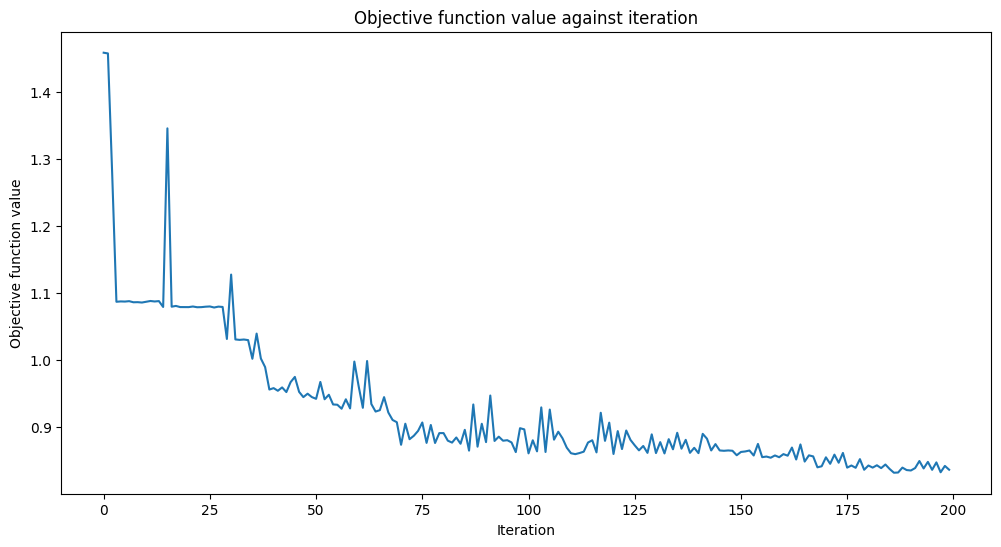

Accuracy from the train data : 74.35%
Accuracy from the test data : 74.48%


In [ ]:
#ELU & sigmiod
x = np.asarray(X_train_encoded[:2000])
y = np.asarray(y_train[:2000])

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)
classifier.save('my_model.h5')
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
y_predict = classifier.predict(X_train_encoded[12000:16000])
x1 = np.asarray(X_train_encoded[12000:16000])
y1 = np.asarray(y_train[12000:16000])
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

In [ ]:
input_dim = 100
encoding_dim = 8  # Target dimensionality

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder1 = keras.Model(input_layer, decoded)
autoencoder1.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder1.fit(X_train1, X_train1, epochs=30, batch_size=32, validation_data=(X_test1, X_test1), verbose=1)

# Create the encoder model
encoder1 = keras.Model(input_layer, encoded)

# Transform data to reduced dimensions
X_train_encoded1 = encoder1.predict(X_train)
X_test_encoded1 = encoder1.predict(X_test)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_encoded1.shape)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0686 - val_loss: 0.0145
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0142 - val_loss: 0.0142
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0137 - val_loss: 0.0140
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0131 - val_loss: 0.0134
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0129 - val_loss: 0.0132
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0129 - val_loss: 0.0131
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0126 - val_loss: 0.0129
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0125 - val_loss: 0.0128
Epoch 10/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 11/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0122 - val_loss: 0.0127
Epoch 12/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

In [ ]:
print(X_train_encoded1[0])

[0.46690044 0.3955404  0.32564864 0.47342676 0.32646057 0.1999655
 0.7083318  0.28577593]


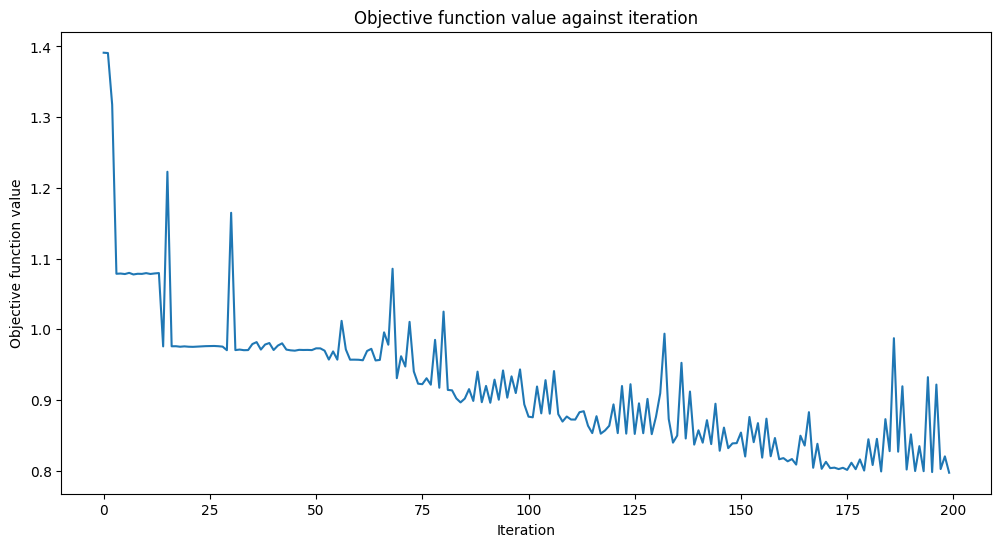

Accuracy from the train data : 74.7%
Accuracy from the test data : 73.58%


In [ ]:
# Relu & sigmoid
x = np.asarray(X_train_encoded1[:4000])
y = np.asarray(y_train[:4000])

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)
classifier.save('my_model.h5')
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
y_predict = classifier.predict(X_train_encoded1[12000:16000])
x1 = np.asarray(X_train_encoded1[12000:16000])
y1 = np.asarray(y_train[12000:16000])
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

In [ ]:
# Elu & sigmoid
input_dim = 100
encoding_dim = 8  # Target dimensionality

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='elu')(input_layer)
encoded = layers.Dense(32, activation='elu')(encoded)
encoded = layers.Dense(16, activation='elu')(encoded)
encoded = layers.Dense(encoding_dim, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='elu')(encoded)
decoded = layers.Dense(32, activation='elu')(encoded)
decoded = layers.Dense(64, activation='elu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder2 = keras.Model(input_layer, decoded)
autoencoder2.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder2.fit(X_train1, X_train1, epochs=50, batch_size=32, validation_data=(X_test1, X_test1), verbose=1)

# Create the encoder model
encoder2 = keras.Model(input_layer, encoded)

# Transform data to reduced dimensions
X_train_encoded2 = encoder2.predict(X_train)
X_test_encoded2 = encoder2.predict(X_test)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_encoded2.shape)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0586 - val_loss: 0.0143
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0138 - val_loss: 0.0141
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0133 - val_loss: 0.0136
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0127 - val_loss: 0.0132
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0125 - val_loss: 0.0130
Epoch 9/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 10/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 11/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0124 - val_loss: 0.0126
Epoch 12/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

In [ ]:
print(X_train_encoded2[0])
len(y_test)

[0.12864189 0.4654697  0.4042916  0.8416791  0.27877897 0.7212829
 0.5917152  0.37990445]


7500

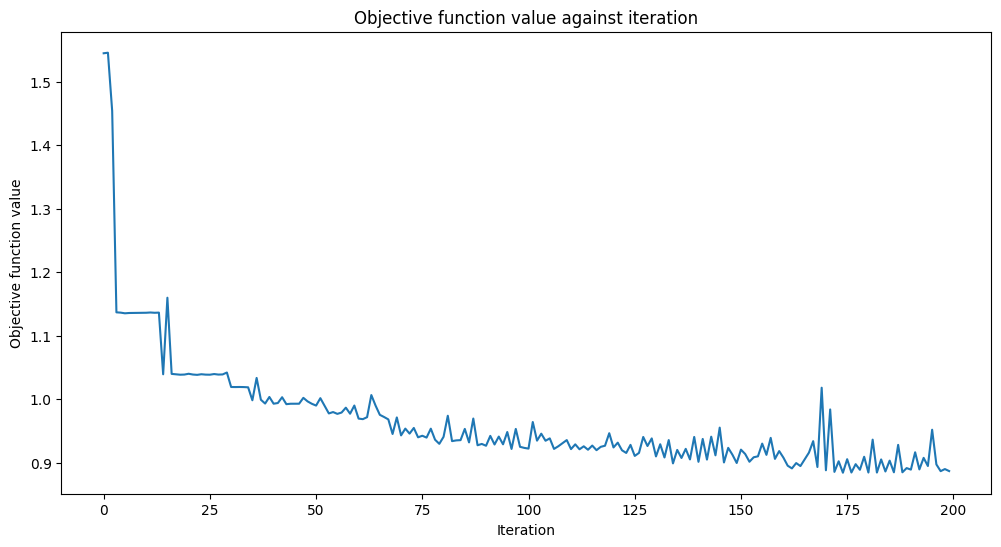

Accuracy from the train data : 76.25%
Accuracy from the test data : 75.86%


In [ ]:
# Elu & sigmoid
x = np.asarray(X_train_encoded2[:6000])
y = np.asarray(y_train[:6000])

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)
classifier.save('my_model.h5')
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
y_predict = classifier.predict(X_train_encoded2[14000:])
x1 = np.asarray(X_train_encoded2[14000:])
y1 = np.asarray(y_train[14000:])
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

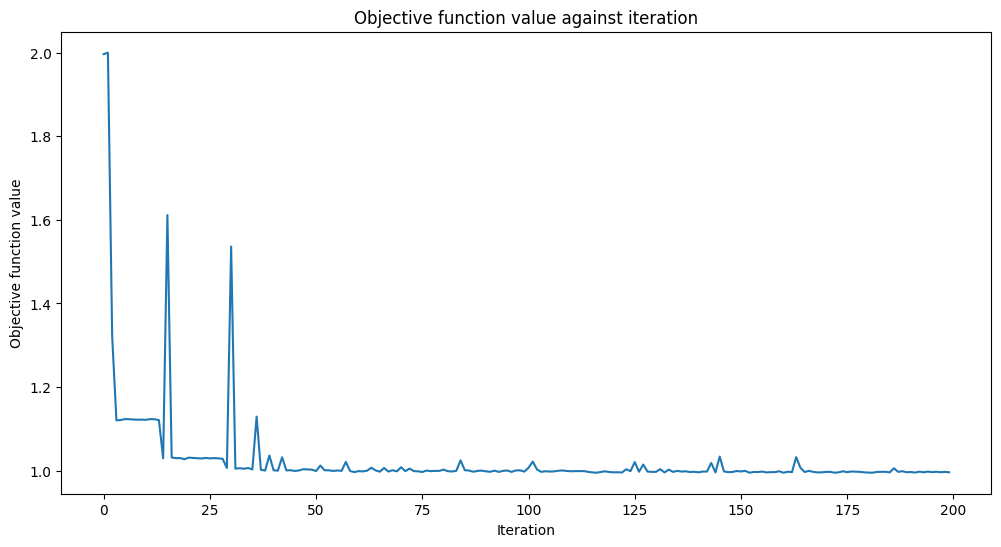

Accuracy from the train data : 52.5%
Accuracy from the test data : 50.8%


In [ ]:
# elu & softmax
x = np.asarray(X_train_encoded2[:1000])
y = np.asarray(y_train[:1000])

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)
classifier.save('my_model.h5')
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
y_predict = classifier.predict(X_train_encoded2[4000:5000])
x1 = np.asarray(X_train_encoded2[4000:5000])
y1 = np.asarray(y_train[4000:5000])
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

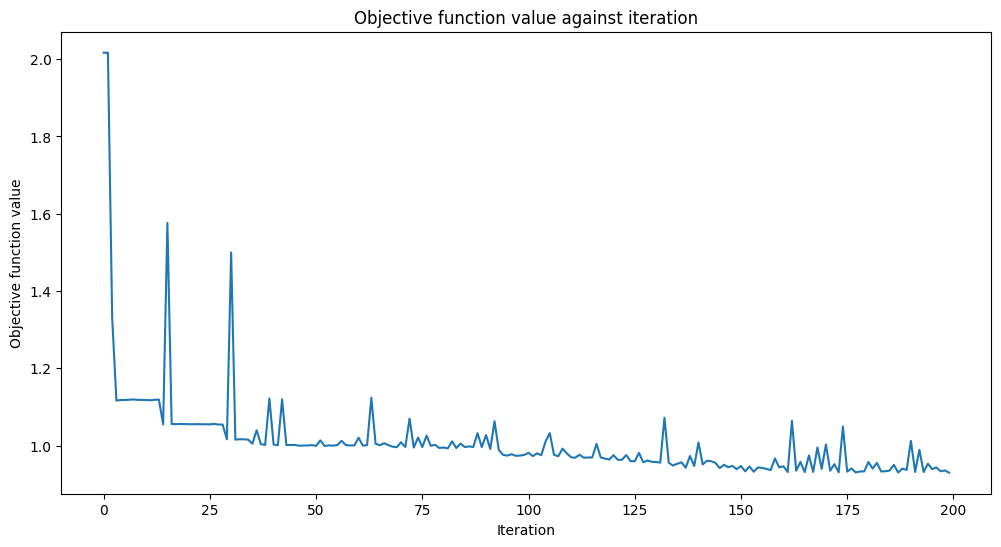

Accuracy from the train data : 62.5%
Accuracy from the test data : 64.05%


In [ ]:
# PCA data with MinMax Scaler
x = np.asarray(X_train_pca3[:2000])
y = np.asarray(y_train[:2000])

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)
classifier.save('my_model.h5')
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
y_predict = classifier.predict(X_train_pca3[12000:14000])
x1 = np.asarray(X_train_pca3[12000:14000])
y1 = np.asarray(y_train[12000:14000])
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

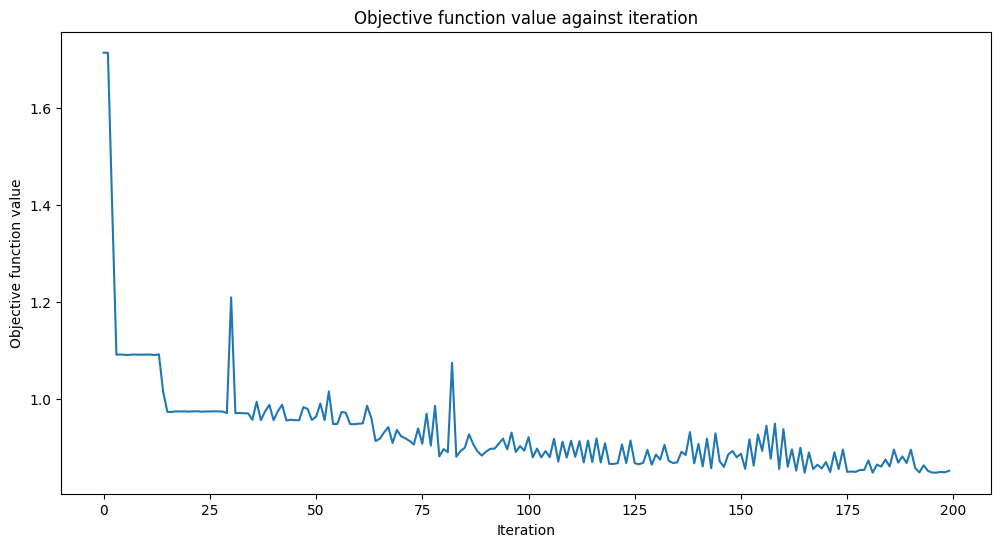

Accuracy from the train data : 78.68%
Accuracy from the test data : 78.55%


In [ ]:
# Elu & sigmoid
x = np.asarray(X_train_encoded2[:6000])
y = np.asarray(y_train[:6000])

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)
classifier.save('my_model.h5')
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
y_predict = classifier.predict(X_test_encoded2[:4000])
x1 = np.asarray(X_test_encoded2[:4000])
y1 = np.asarray(y_test[:4000])
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")